# GCCR002: COVID prediction from GCCR data

In [1]:
# Imports
#%load_ext lab_black
%load_ext autoreload
%autoreload 2
from gccr002 import *
import figures
import tables
import time

start = time.time()

# Figure styles
sns.set_style("whitegrid")
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titleweight"] = "bold"

figures.SAVE = False
tables.SAVE = True

### Load the pre-processed data and diagnosis classes (see pre-analysis notebook)

In [2]:
# All of the content loaded here was produced in pre-analysis.ipynb
df, Xu, Xn, dtypes, s, classes = load_all()
original_cols = list(df)

In [3]:
# A universal cross-validation splitter
sh_split = ShuffleSplit(100, random_state=0)

In [4]:
# All 4
diagnoses = {
    "C19+": s["lab-covid"],
    "C19+ (Clinical)": s["clinical-covid"],
    "Unknown": s["unknown-covid"],
    "C19-": s["non-covid"],
}

# Only Lab + and Clinical +
diagnoses["plus"] = {key: diagnoses[key] for key in diagnoses if "+" in key}

# All but unknown
diagnoses["known"] = {
    key: diagnoses[key] for key in diagnoses if "+" in key or "-" in key
}

# Only Lab + and Lab -
diagnoses["clean"] = {
    key: diagnoses[key] for key in diagnoses if len(key) == 4 and "C19" in key
}

# Quick COVID status lookup (not to be placed in X)
df = status_map(df, diagnoses, "COVID Status (All)")
df = status_map(df, diagnoses["clean"], "COVID Status")

features = list(
    chain(
        *[
            classes["features"][kind]
            for kind in ["chemosensory", "typical", "history", "demographic"]
        ]
    )
)
senses = colors.index.get_level_values("sense").unique()
X = Xn.loc[s["lab-covid"] | s["non-covid"], features].sort_index()
y = X.index.to_series().isin(s["lab-covid"])
sample_weight = None

lr = LogisticRegression(
    penalty="elasticnet",
    solver="saga",
    C=10,
    l1_ratio=1,
    max_iter=10000,
    random_state=0,
)

lrcv = LogisticRegressionCV(
    penalty="elasticnet",
    solver="saga",
    Cs=[10],
    n_jobs=sh_split.n_splits,
    l1_ratios=[1],
    max_iter=10000,
    random_state=0,
    cv=sh_split,
    scoring="roc_auc",
)

s["no_chem_or_block"] = get_set(
    df, "Chemesthesis_during_illness < 20 & Blocked_nose_during_illness < 20"
)
s["no_chem_but_block"] = get_set(
    df, "Chemesthesis_during_illness < 20 & Blocked_nose_during_illness >= 20"
)
s["chem_no_block"] = get_set(
    df, "Chemesthesis_during_illness >= 20 & Blocked_nose_during_illness < 20"
)
s["chem_and_block"] = get_set(
    df, "Chemesthesis_during_illness >= 20 & Blocked_nose_during_illness >= 20"
)

### Figure 2

Smell (during): C19+ = 8.97 +/- 20.8; C19- = 28.8 +/- 33.5; p=1.08e-59
Smell (before): C19+ = 91.4 +/- 16.2; C19- = 88.6 +/- 18.1; p=3.22e-05


/home/rgerkin/Dropbox (ASU)/olfaction/gccr/GCCR002-private/gccr002.py:477: UserWarning: FixedFormatter should only be used together with FixedLocator
  getattr(ax, 'set_%sticklabels' % xy)(new)


Taste (during): C19+ = 21.1 +/- 27.9; C19- = 34.4 +/- 33.5; p=7.08e-24
Taste (before): C19+ = 92.7 +/- 13.6; C19- = 89.7 +/- 16.9; p=1.75e-06


/home/rgerkin/Dropbox (ASU)/olfaction/gccr/GCCR002-private/gccr002.py:477: UserWarning: FixedFormatter should only be used together with FixedLocator
  getattr(ax, 'set_%sticklabels' % xy)(new)


Chemesthesis (during): C19+ = 44.4 +/- 32.2; C19- = 50.2 +/- 31.5; p=4.57e-05
Chemesthesis (before): C19+ = 81.2 +/- 24.5; C19- = 78.9 +/- 25.5; p=0.016


/home/rgerkin/Dropbox (ASU)/olfaction/gccr/GCCR002-private/gccr002.py:477: UserWarning: FixedFormatter should only be used together with FixedLocator
  getattr(ax, 'set_%sticklabels' % xy)(new)


Blocked Nose (during): C19+ = 35 +/- 32; C19- = 37.8 +/- 32.8; p=0.0578
Blocked Nose (before): C19+ = 9.37 +/- 17.3; C19- = 11.8 +/- 19.6; p=0.00387


/home/rgerkin/Dropbox (ASU)/olfaction/gccr/GCCR002-private/gccr002.py:477: UserWarning: FixedFormatter should only be used together with FixedLocator
  getattr(ax, 'set_%sticklabels' % xy)(new)


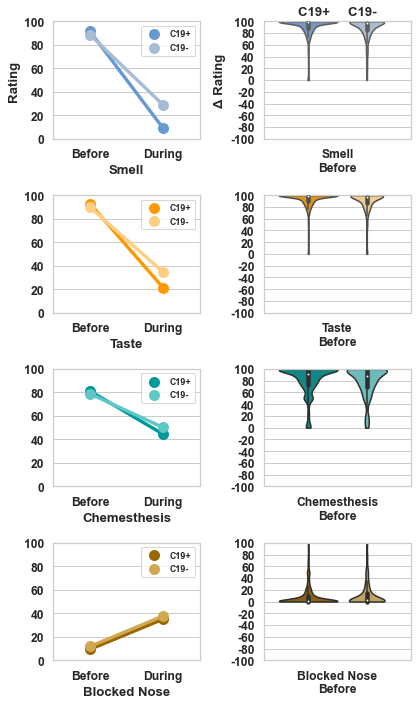

In [5]:
figures.senses_summary(df, s, senses, left=["before", "during"], right=["before"])

Smell (during): C19+ = 8.97 +/- 20.8; C19- = 28.8 +/- 33.5; p=1.08e-59
Smell (change): C19+ = -82.4 +/- 27.2; C19- = -59.8 +/- 37.7; p=2.23e-46


/home/rgerkin/Dropbox (ASU)/olfaction/gccr/GCCR002-private/gccr002.py:477: UserWarning: FixedFormatter should only be used together with FixedLocator
  getattr(ax, 'set_%sticklabels' % xy)(new)


Taste (during): C19+ = 21.1 +/- 27.9; C19- = 34.4 +/- 33.5; p=7.08e-24
Taste (change): C19+ = -71.6 +/- 31.8; C19- = -55.2 +/- 37.5; p=6.71e-26


/home/rgerkin/Dropbox (ASU)/olfaction/gccr/GCCR002-private/gccr002.py:477: UserWarning: FixedFormatter should only be used together with FixedLocator
  getattr(ax, 'set_%sticklabels' % xy)(new)


Chemesthesis (during): C19+ = 44.4 +/- 32.2; C19- = 50.2 +/- 31.5; p=4.57e-05
Chemesthesis (change): C19+ = -36.8 +/- 37.1; C19- = -28.7 +/- 37.1; p=2.45e-07


/home/rgerkin/Dropbox (ASU)/olfaction/gccr/GCCR002-private/gccr002.py:477: UserWarning: FixedFormatter should only be used together with FixedLocator
  getattr(ax, 'set_%sticklabels' % xy)(new)


Blocked Nose (during): C19+ = 35 +/- 32; C19- = 37.8 +/- 32.8; p=0.0578
Blocked Nose (change): C19+ = 25.6 +/- 32.7; C19- = 26 +/- 32.4; p=0.395


/home/rgerkin/Dropbox (ASU)/olfaction/gccr/GCCR002-private/gccr002.py:477: UserWarning: FixedFormatter should only be used together with FixedLocator
  getattr(ax, 'set_%sticklabels' % xy)(new)


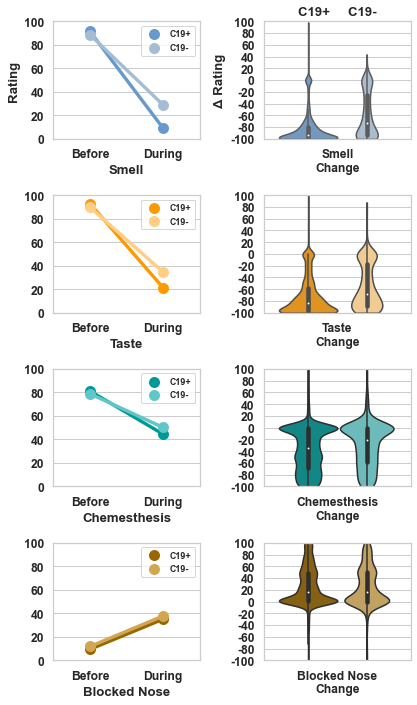

In [6]:
figures.CONTEXT = 2
figures.senses_summary(df, s, senses, left=["before", "during"], right=["change"])

### Figure 3

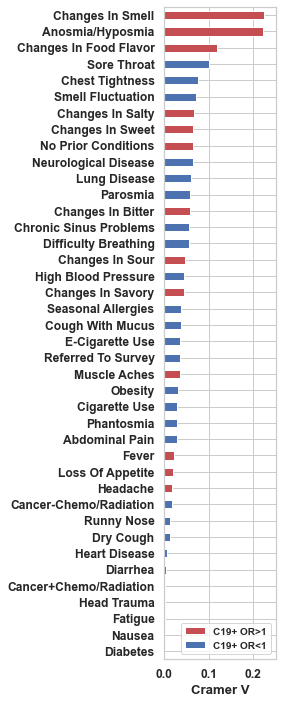

In [7]:
figures.CONTEXT = 3
figures.cramer_vs(df, classes)

### Comparison of models under various inclusion/exclusion criteria for recovery from respiratory symptoms

In [8]:
# All recovery states
X = Xn.loc[s["lab-covid"] | s["non-covid"], features].sort_index()
y = X.index.to_series().isin(s["lab-covid"])

# Only those with neither partial nor full respiratory recovery
X_nr = Xn.loc[(s["lab-covid"] | s["non-covid"]) - s["resp-recovery"], features].sort_index()
y_nr = X_nr.index.to_series().isin(s["lab-covid"])

# Only those without full respiratory recovery
X_sr = Xn.loc[(s["lab-covid"] | s["non-covid"]) - s["full-resp-recovery"], features].sort_index()
y_sr = X_sr.index.to_series().isin(s["lab-covid"])

# Only those *with* full respiratory recovery
X_r = Xn.loc[(s["lab-covid"] | s["non-covid"]) & s["full-resp-recovery"], features].sort_index()
y_r = X_r.index.to_series().isin(s["lab-covid"])

In [9]:
# Single feature models; no recovery constraints
single_feature_aucs = get_tuple_feature_aucs(
    lrcv, X, y, 1, sample_weight=sample_weight, nicify_=False
)
single_feature_aucs.head(5)

,ROC AUC
Symptom set,
Smell_during_illness,0.709
Smell_change_illness,0.684
Taste_change_illness,0.635
Taste_during_illness,0.630
Changes_in_smell_i_cannot_smell_at_all_/_smells_smell_less_strong_than_they_did_before,0.620


In [10]:
# Dual feature models; no recovery constraints
single_feature_aucs_w_smell = get_tuple_feature_aucs(
    lrcv,
    X,
    y,
    1,
    sample_weight=sample_weight,
    nicify_=False,
    add_to=["Smell_during_illness"],
)
single_feature_aucs_w_smell.head()

,ROC AUC
Symptom set,
Days_since_onset,0.719
Combustible_cigarette_use,0.717
Prior_conditions_high_blood_pressure,0.715
Prior_conditions_obesity,0.715
Symptoms_muscle_aches,0.714


In [11]:
# Single feature models; only those *with* full respiratory recovery!
single_feature_aucs = get_tuple_feature_aucs(
    lrcv, X_r, y_r, 1, sample_weight=sample_weight, nicify_=False
)
single_feature_aucs.head(5)

,ROC AUC
Symptom set,
Smell_during_illness,0.650
Smell_change_illness,0.633
Taste_change_illness,0.590
Changes_in_smell_i_cannot_smell_at_all_/_smells_smell_less_strong_than_they_did_before,0.585
Taste_during_illness,0.575


In [12]:
# Two feature models; only those *with* full respiratory recovery!
single_feature_aucs_w_smell = get_tuple_feature_aucs(
    lrcv,
    X_r,
    y_r,
    1,
    sample_weight=sample_weight,
    nicify_=False,
    add_to=["Smell_during_illness"],
)
single_feature_aucs_w_smell.head()

,ROC AUC
Symptom set,
Days_since_onset,0.667
Onset_day,0.661
Combustible_cigarette_use,0.659
Chemesthesis_during_illness,0.658
Prior_conditions_lung_disease_(asthma/copd),0.658


In [13]:
# Single feature models; only those with neither partial nor full respiratory recovery!
single_feature_aucs = get_tuple_feature_aucs(
    lrcv, X_nr, y_nr, 1, sample_weight=sample_weight, nicify_=False
)
single_feature_aucs.head(5)

,ROC AUC
Symptom set,
Smell_during_illness,0.758
Smell_change_illness,0.722
Days_since_onset,0.669
Taste_during_illness,0.650
Chemesthesis_during_illness,0.642


In [14]:
# Dual feature models; Only those with neither partial nor full respiratory recovery!
single_feature_aucs_w_smell = get_tuple_feature_aucs(
    lrcv,
    X_nr,
    y_nr,
    1,
    sample_weight=sample_weight,
    nicify_=False,
    add_to=["Smell_during_illness"],
)
single_feature_aucs_w_smell.head()

,ROC AUC
Symptom set,
Days_since_onset,0.788
Prior_conditions_cancer_that_required_chemotherapy_or_radiation,0.776
Symptoms_muscle_aches,0.773
Chemesthesis_change_illness,0.771
Prior_conditions_heart_disease_(heart_attack_or_stroke),0.768


In [15]:
# Singlefeature models; only those without full respiratory recovery!
single_feature_aucs = get_tuple_feature_aucs(
    lrcv, X_sr, y_sr, 1, sample_weight=sample_weight, nicify_=False
)
single_feature_aucs.head(5)

,ROC AUC
Symptom set,
Smell_during_illness,0.734
Smell_change_illness,0.713
Taste_change_illness,0.672
Taste_during_illness,0.668
Changes_in_smell_i_cannot_smell_at_all_/_smells_smell_less_strong_than_they_did_before,0.635


In [16]:
# Dual feature models; Only those without full respiratory recovery!
single_feature_aucs_w_smell = get_tuple_feature_aucs(
    lrcv,
    X_sr,
    y_sr,
    1,
    sample_weight=sample_weight,
    nicify_=False,
    add_to=["Smell_during_illness"],
)
single_feature_aucs_w_smell.head()

,ROC AUC
Symptom set,
Days_since_onset,0.760
Symptoms_muscle_aches,0.743
Changes_in_basic_tastes_savory/umami,0.742
Taste_before_illness,0.742
Prior_conditions_obesity,0.741


In [17]:
# No constraints on recovery
# Best model, with error bars and p-values, in natural units
tables.fit_and_coefs(
    Xu.loc[y.index].clip(0, 30), y, ["Smell_during_illness", "Days_since_onset"]
)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.32223381291926506
            Iterations: 33
            Function evaluations: 33
            Gradient evaluations: 33


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,2.2,0.05,42,0,2.1,2.4
Smell During,-0.07,0.0039,-19,2.7e-78,-0.078,-0.063
Days Since Onset,-0.015,0.0052,-2.8,0.0057,-0.024,-0.0042


In [18]:
# Only those with neither partial nor full respiratory recovery
# Best model, with error bars and p-values, in natural units
X_nru = Xu.loc[(s["lab-covid"] | s["non-covid"]) - s["resp-recovery"], features].sort_index()
y_nru = X_nru.index.to_series().isin(s["lab-covid"])

tables.fit_and_coefs(
    X_nru.loc[y_nru.index].clip(0, 30), y_nru, ["Smell_during_illness", "Days_since_onset"]
)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.3310160749741913
            Iterations: 34
            Function evaluations: 55
            Gradient evaluations: 34


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,2.2,0.13,17,2.1e-64,1.9,2.5
Smell During,-0.083,0.0089,-9.3,8.9e-21,-0.1,-0.065
Days Since Onset,-0.044,0.011,-4.2,2.8e-05,-0.064,-0.023


### All subsequent analysis has no constraints on respiratory recovery except as indicated

/home/rgerkin/Dropbox (ASU)/olfaction/gccr/GCCR002-private/gccr002.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(feature_names)
/home/rgerkin/Dropbox (ASU)/olfaction/gccr/GCCR002-private/gccr002.py:1203: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(nicify(feature_names))
/home/rgerkin/Dropbox (ASU)/olfaction/gccr/GCCR002-private/figures.py:464: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['+%s' % x.get_text() for x in ax.get_yticklabels()]);


(0.0, 0.1)

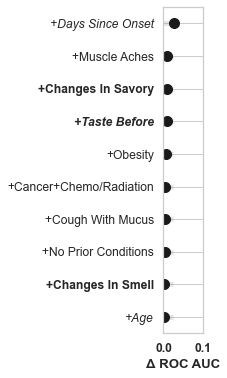

In [19]:
figures.single_auc_delta(
    single_feature_aucs_w_smell,
    single_feature_aucs.values[0],
    classes,
    figsize=(0.7, 6),
)
plt.gca().set_xlim(0, 0.1)

In [20]:
single_feature_aucs_w_smell = get_tuple_feature_aucs(
    lrcv,
    X,
    y,
    1,
    sample_weight=sample_weight,
    nicify_=False,
    add_to=["Smell_during_illness"],
)

/home/rgerkin/Dropbox (ASU)/olfaction/gccr/GCCR002-private/gccr002.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(feature_names)
/home/rgerkin/Dropbox (ASU)/olfaction/gccr/GCCR002-private/gccr002.py:1203: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(nicify(feature_names))


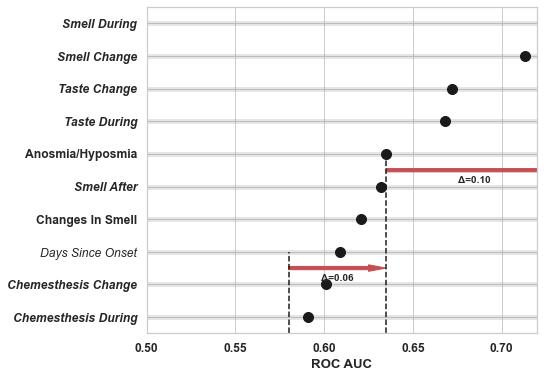

In [21]:
figures.single_auc(single_feature_aucs, classes, figsize=(7, 6))
plt.xticks(np.arange(0.5, 0.75, 0.05));

/home/rgerkin/Dropbox (ASU)/olfaction/gccr/GCCR002-private/gccr002.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(feature_names)
/home/rgerkin/Dropbox (ASU)/olfaction/gccr/GCCR002-private/gccr002.py:1203: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(nicify(feature_names))
/home/rgerkin/Dropbox (ASU)/olfaction/gccr/GCCR002-private/figures.py:464: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['+%s' % x.get_text() for x in ax.get_yticklabels()]);
<ipython-input-22-2af98179fcc5>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([0, 0.025])


[Text(0.0, 0, '0'), Text(0.025, 0, '0.025')]

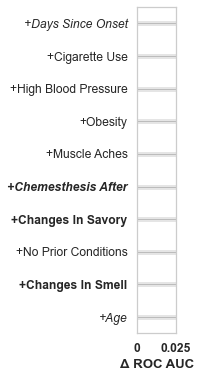

In [22]:
figures.single_auc_delta(
    single_feature_aucs_w_smell,
    single_feature_aucs.values[0],
    classes,
    figsize=(0.7, 6),
)
plt.gca().set_xticklabels([0, 0.025])

Smell: Sens50 = 0.845, Spec50 = 0.749
DSO: Sens50 = 0.537, Spec50 = 0.533
Smell+DSO: Sens50 = 0.813, Spec50 = 0.793
Fever+Cough+Dyspnea(CDC3): Sens50 = 0.547, Spec50 = 0.539
Smell+DSO+CDC3: Sens50 = 0.814, Spec50 = 0.762
Full: Sens50 = 0.822, Spec50 = 0.77


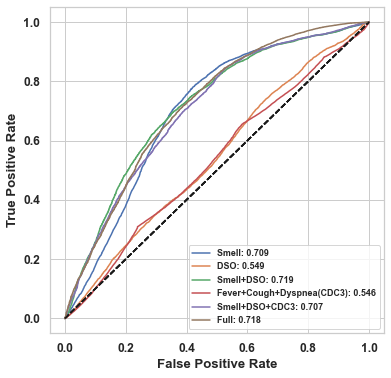

In [23]:
classes["features"].update(
    {
        "Smell": ["Smell_during_illness"],
        "DSO": ["Days_since_onset"],
        "Full": features,
        "Fever+Cough+Dyspnea(CDC3)": classes["features"]["CDC3"],
    }
)
class_sets = [
    ("Smell",),
    ("DSO",),
    ("Smell", "DSO"),
    ("Fever+Cough+Dyspnea(CDC3)",),
    ("Smell", "DSO", "CDC3"),
    ("Full",),
]
figures.all_rocs(lr, X, y, classes, class_sets, sh_split);

In [24]:
# Best model, with error bars and p-values, in natural units
tables.fit_and_coefs(
    Xu.loc[y.index].clip(0, 30), y, ["Smell_during_illness", "Days_since_onset"]
)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.32223381291926506
            Iterations: 33
            Function evaluations: 33
            Gradient evaluations: 33


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,2.2,0.05,42,0,2.1,2.4
Smell During,-0.07,0.0039,-19,2.7e-78,-0.078,-0.063
Days Since Onset,-0.015,0.0052,-2.8,0.0057,-0.024,-0.0042


In [25]:
z = tables.conf_mat_stats2(
    Xu,
    y,
    [
        ("Smell_during_illness", 30, -1),
        ("Smell_during_illness", 13, -1),
        ("Smell_during_illness", 1, -1),
        ("Smell_during_illness", 0.1, -1),
        ("Symptoms_changes_in_smell", 0.5, 1),
        ("Symptoms_fever", 0.5, 1),
        ("Symptoms_dry_cough", 0.5, 1),
        ("Symptoms_difficulty_breathing_/_shortness_of_breath", 0.5, 1),
    ],
)
z.rename(index={"Smell During < 0.1": "Total Smell Loss"})

,Sensitivity,Specificity,Odds Ratio
Feature,,,
Smell During < 30,0.91,0.34,5.44
Smell During < 13,0.85,0.51,5.68
Smell During < 1,0.51,0.75,3.13
Total Smell Loss,0.36,0.83,2.61
Changes In Smell,0.92,0.29,4.89
Fever,0.54,0.49,1.15
Dry Cough,0.52,0.46,0.92
Difficulty Breathing,0.35,0.57,0.70


In [26]:
# figures.CONTEXT = "Not used"
# figures.plot_clipped_auc(lrcv, Xu, y, "Smell_during_illness")

### Figure 4

In [27]:
# The three smell loss and recovery clusters
s["intact-smell"] = get_set(df, "Smell_change_illness > -33.3")
s["severe-smell-loss"] = get_set(df, "Smell_change_illness < -33.3")
s["recovered-smell"] = get_set(
    df, "Smell_change_illness < -33.3 & Smell_recovery_illness > 33.3"
)
s["nonrecovered-smell"] = get_set(
    df, "Smell_change_illness < -33.3 & Smell_recovery_illness <= 33.3"
)

three_clusters = {
    "Intact\nSmell": s["recovery-data"] & s["intact-smell"],
    "Recovered\nSmell": s["recovery-data"] & s["recovered-smell"],
    "Persistent\nSmell Loss": s["recovery-data"] & s["nonrecovered-smell"],
}

/home/rgerkin/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/rgerkin/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:1678: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0`, but please update your code.
  warnings.warn(msg, UserWarning)
/home/rgerkin/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/rgerkin/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:1678: UserWarning: `s

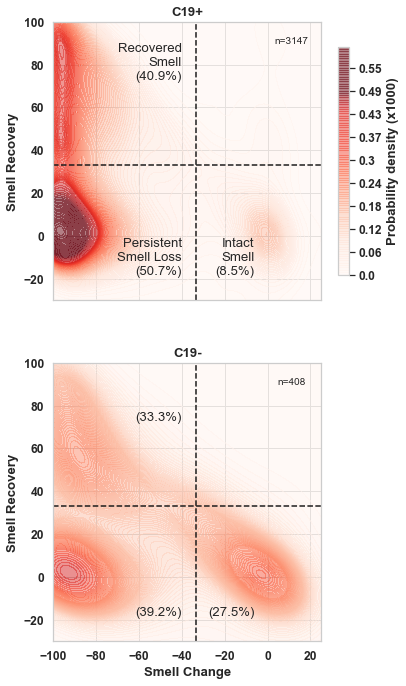

In [28]:
figures.CONTEXT = 4
figures.contour_plots(
    df, s, "Smell_change_illness", "Smell_recovery_illness", three_clusters
)
figures.save_fig('contour_plots')

In [29]:
# Compute cluster statistics
for_clustering = df.loc[s["lab-covid"] & s["recovery-data"]][['Smell_change_illness', 'Smell_recovery_illness']]

from sklearn.cluster import KMeans

def optimalK(data, nrefs=3, maxClusters=15):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):

        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)

        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_

        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)

    return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal

optimalK(for_clustering)

(12,
     clusterCount       gap
 0            1.0 -9.410826
 1            2.0 -9.212915
 2            3.0 -8.935542
 3            4.0 -9.114063
 4            5.0 -8.997496
 5            6.0 -8.982248
 6            7.0 -8.940208
 7            8.0 -8.954842
 8            9.0 -8.973688
 9           10.0 -8.936483
 10          11.0 -8.932031
 11          12.0 -8.918971
 12          13.0 -8.925405
 13          14.0 -8.951476)

In [30]:
labels_formal = pd.Series(KMeans(3).fit(for_clustering).labels_, index=for_clustering.index, name='labels_formal')
def cluster_map(x):
    if x['Smell_change_illness'] > -33.3:
        return 2
    elif x['Smell_recovery_illness'] > 33.3:
        return 1
    else:
        return 0
labels_informal = for_clustering.apply(cluster_map, axis=1)
labels_informal.name = 'labels_informal'
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(labels_formal, labels_informal)
z = for_clustering.join(labels_formal).join(labels_informal)
agreement = np.diag(pd.crosstab(z['labels_formal'], z['labels_informal'])).sum() / pd.crosstab(z['labels_formal'], z['labels_informal']).sum().sum()
print("Agreement between manual and unsupervised clusters is %.3g" % agreement)

Agreement between manual and unsupervised clusters is 0.955


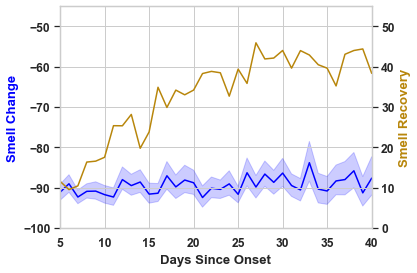

In [31]:
figures.CONTEXT = 4
figures.feature_vs_days(
    df, s, restrict=s["severe-smell-loss"] & s["lab-covid"], features=["Smell_change_illness", "Smell_recovery_illness"]
)

In [32]:
tables.big_table(df, s, three_clusters, sem=False)

In [33]:
# figures.odds_ratios_cutoff(
#    df,
#    diagnoses,
#    "Smell_during_illness",
#    binary="Changes_in_smell_i_cannot_smell_at_all_/_smells_smell_less_strong_than_they_did_before",
#    xlim=(1, 6),
# )

In [34]:
# figures.CONTEXT = "Not used"
# figures.which_cluster(df, classes, s, three_clusters)

### Figure 5

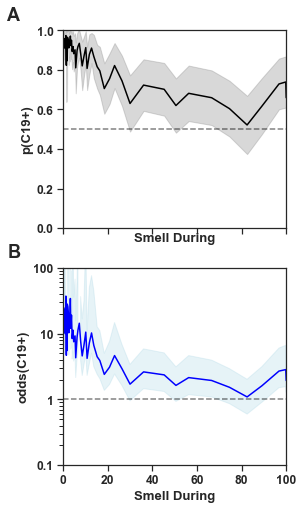

In [35]:
figures.CONTEXT = 5
figures.odds_figure(Xu, y, "Smell_during_illness")

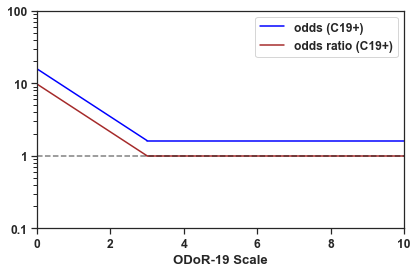

In [36]:
figures.CONTEXT = 5
figures.odds_cartoon()

## Supplement

In [37]:
# three_clusters_pos = {
#    key: three_clusters[key] & s["lab-covid"] for key in three_clusters
# }
#
# cluster_summary(df, three_clusters_pos, s, "Age")

In [38]:
# cluster_summary(df, three_clusters_pos, s, "Days_since_onset")

In [39]:
# cluster_summary(df, three_clusters_pos, s, "Onset_day")

In [40]:
# Contingency table for the three clusters vs two genders, normalize row probabilities to add to 1.
# Set normalize to 0 to make column probabilities add to 1.  Set normalize to None to show counts.
# Men are less likely to have smell loss in the first place, but somewhat more likely to regain it if it is lost
# feature_contingency(df, three_clusters_pos, "Gender", drop=["2.0", "3.0"], normalize=1)

In [41]:
# Same as above but only given smell loss
# Men still recover significantly more often than women (or just use the scale differently)
# two_clusters_pos = {
#    key: value
#    for key, value in three_clusters_pos.items()
#    if key in ["Persistent\nSmell Loss", "Recovered\nSmell"]
# }
# feature_contingency(df, two_clusters_pos, "Gender", drop=["2.0", "3.0"], normalize=1)

In [42]:
# Distractors
drop = get_matches(
    Xu,
    [
        "Test_Name",
        "Referred",
        "GCCR",
        "Changes_in_smell_i_cannot_smell_at_all_",
        "Symptoms_changes_in_smell",
        "Gender_F",
        "3.0",
        "2.0",
        "Recovery_y/n",
        "after_illness",
        "recovery_illness",
        "Smell_during",
        "Onset_day",
        "Completion_day",
    ],
)
# Restrictions
r = s["resp-recovery"] & s["recovery-data"] & s["severe-smell-loss"] & s["lab-covid"]
r = sorted(r)
# Covariates
X = Xn.loc[r].drop(drop, axis=1)
# Target
y = Xu.loc[r]["Smell_recovery_illness"] > 33.3

### Recovery Prediction Model

In [43]:
# Single feature models
lrcv = LogisticRegressionCV(
    penalty="elasticnet",
    solver="saga",
    Cs=[1],
    l1_ratios=[1],
    max_iter=10000,
    random_state=0,
    cv=sh_split,
    scoring="roc_auc",
)
sample_weight = get_weights(X, y, "balanced-by-country")
single_feature_aucs_recovery = get_tuple_feature_aucs(
    lrcv, X, y, 1, sample_weight=sample_weight
)
single_feature_aucs_recovery.head(5)

,ROC AUC
Symptom set,
Days Since Onset,0.621
Blocked Nose Change,0.541
Changes In Savory,0.538
Blocked Nose During,0.535
Age,0.530


In [44]:
# features = list(
#    chain(
#        *[
#            classes["features"][kind]
#            for kind in ["chemosensory", "typical", "history", "demographic"]
#        ]
#    )
# )

In [45]:
# X = Xn.loc[s["lab-covid"] | s["non-covid"], features]
# y = X.index.to_series().isin(s["lab-covid"])
# tables.predict_others(lr, X, Xn, y, s, classes, class_weights="balanced")

### Comparison between GCCR and YouGov

In [46]:
yg_countries = download_yougov()

https://raw.githubusercontent.com/YouGov-Data/covid-19-tracker/master/data/france.zip
https://raw.githubusercontent.com/YouGov-Data/covid-19-tracker/master/data/sweden.zip
https://raw.githubusercontent.com/YouGov-Data/covid-19-tracker/master/data/united-kingdom.zip



In [47]:
yg_gccr_rs = compute_gccr_yougov_corr(df, s, yg_countries)

/home/rgerkin/miniconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


GCCR_N    3962
YG_N      8601
dtype: int64


/home/rgerkin/miniconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [48]:
# country_of_residence = pd.read_csv("country-of-residence.csv", index_col=0)
# df_ = df.join(country_of_residence, how="inner")
# df_["yg_week"] = yg_week(df_, offset=0, how="Completion_day")
# yougov = get_yougov(df_, yg_countries)
# gccr_yougov = compare_yougov(df_, yougov, s)

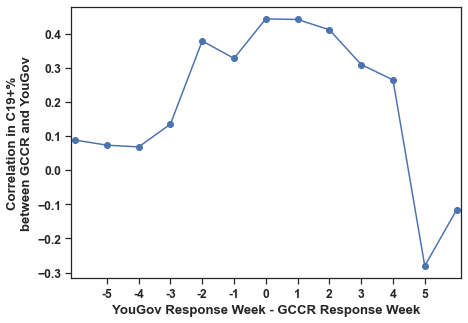

In [49]:
figures.CONTEXT = "Supplement"
figures.plot_yougov(yg_gccr_rs)

In [50]:
tables.yougov_odds_ratios()

,N,% C19+,% C19-,OR (C19+ vs C19-),OR(C19+ vs Not Tested),OR(C19- vs Not Tested),p(Smell Loss | C19+)
!!Global,109395,0.51,3,5.96,49.7,8.33,0.33
!Global,8796,0.51,3,8.19,59,9.03,0.34
Brazil,4167,0.91,5.4,8.39,33.9,4.04,0.47
Canada,5524,0.47,3.4,7.76,71.6,9.22,0.35
Denmark,5839,0.36,5.7,9.35,77.8,8.32,0.33
Finland,5927,0.32,1.9,1.85,27.8,15.1,0.21
France,9820,0.46,1.7,7,57.9,8.27,0.29
Germany,9468,0.49,2.1,4.56,94.2,20.7,0.37
Italy,9790,0.33,2.8,9.17,50.8,5.54,0.22
Mexico,5840,0.24,3.5,8.91,27.6,3.1,0.21


### Details of Chemosensory Recovery

Smell (after): C19+ = 39.5 +/- 34.7; C19- = 51.9 +/- 35.3; p=1.82e-11
Smell (recovery): C19+ = 30.2 +/- 35.6; C19- = 24.6 +/- 31.9; p=0.000232


/home/rgerkin/Dropbox (ASU)/olfaction/gccr/GCCR002-private/gccr002.py:477: UserWarning: FixedFormatter should only be used together with FixedLocator
  getattr(ax, 'set_%sticklabels' % xy)(new)


Taste (after): C19+ = 49.8 +/- 33.6; C19- = 57.2 +/- 33.7; p=1.48e-05
Taste (recovery): C19+ = 28.3 +/- 34.6; C19- = 22.7 +/- 35.2; p=0.00153


/home/rgerkin/Dropbox (ASU)/olfaction/gccr/GCCR002-private/gccr002.py:477: UserWarning: FixedFormatter should only be used together with FixedLocator
  getattr(ax, 'set_%sticklabels' % xy)(new)


Chemesthesis (after): C19+ = 62.4 +/- 29.1; C19- = 62.8 +/- 28.7; p=0.425
Chemesthesis (recovery): C19+ = 17.3 +/- 30.9; C19- = 15 +/- 31.3; p=0.0941


/home/rgerkin/Dropbox (ASU)/olfaction/gccr/GCCR002-private/gccr002.py:477: UserWarning: FixedFormatter should only be used together with FixedLocator
  getattr(ax, 'set_%sticklabels' % xy)(new)


Blocked Nose (after): C19+ = 18.8 +/- 24.5; C19- = 22.8 +/- 26; p=0.000491
Blocked Nose (recovery): C19+ = -16 +/- 27.8; C19- = -14.4 +/- 27.3; p=0.074


/home/rgerkin/Dropbox (ASU)/olfaction/gccr/GCCR002-private/gccr002.py:477: UserWarning: FixedFormatter should only be used together with FixedLocator
  getattr(ax, 'set_%sticklabels' % xy)(new)


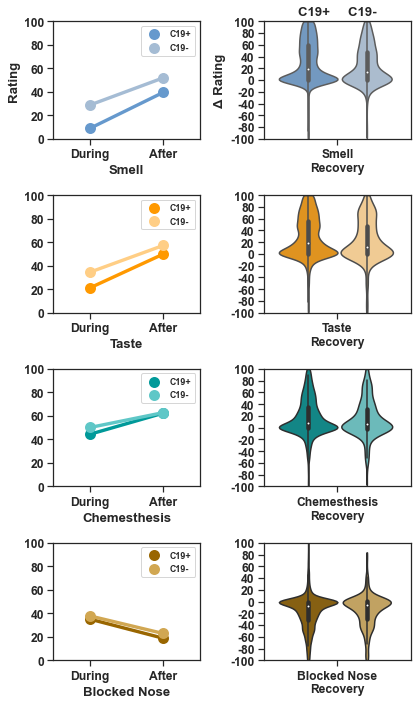

In [51]:
# Without filtering out those who have not yet recovered from respiratory illness
figures.CONTEXT = "Supplement"
figures.senses_summary(df, s, senses, left=["during", "after"], right=["recovery"])

Smell (after): C19+ = 39.8 +/- 34.7; C19- = 52.2 +/- 35.2; p=2.77e-11
Smell (recovery): C19+ = 30.5 +/- 35.7; C19- = 24.6 +/- 31.9; p=0.000215


/home/rgerkin/Dropbox (ASU)/olfaction/gccr/GCCR002-private/gccr002.py:477: UserWarning: FixedFormatter should only be used together with FixedLocator
  getattr(ax, 'set_%sticklabels' % xy)(new)


Taste (after): C19+ = 50.1 +/- 33.5; C19- = 57.3 +/- 33.6; p=2.59e-05
Taste (recovery): C19+ = 28.5 +/- 34.6; C19- = 22.5 +/- 35.2; p=0.000981


/home/rgerkin/Dropbox (ASU)/olfaction/gccr/GCCR002-private/gccr002.py:477: UserWarning: FixedFormatter should only be used together with FixedLocator
  getattr(ax, 'set_%sticklabels' % xy)(new)


Chemesthesis (after): C19+ = 62.6 +/- 28.9; C19- = 62.9 +/- 28.6; p=0.466
Chemesthesis (recovery): C19+ = 17.3 +/- 30.9; C19- = 15 +/- 30.7; p=0.0729


/home/rgerkin/Dropbox (ASU)/olfaction/gccr/GCCR002-private/gccr002.py:477: UserWarning: FixedFormatter should only be used together with FixedLocator
  getattr(ax, 'set_%sticklabels' % xy)(new)


Blocked Nose (after): C19+ = 18.8 +/- 24.6; C19- = 22.6 +/- 25.9; p=0.00132
Blocked Nose (recovery): C19+ = -16.2 +/- 28; C19- = -14.9 +/- 27.3; p=0.11


/home/rgerkin/Dropbox (ASU)/olfaction/gccr/GCCR002-private/gccr002.py:477: UserWarning: FixedFormatter should only be used together with FixedLocator
  getattr(ax, 'set_%sticklabels' % xy)(new)


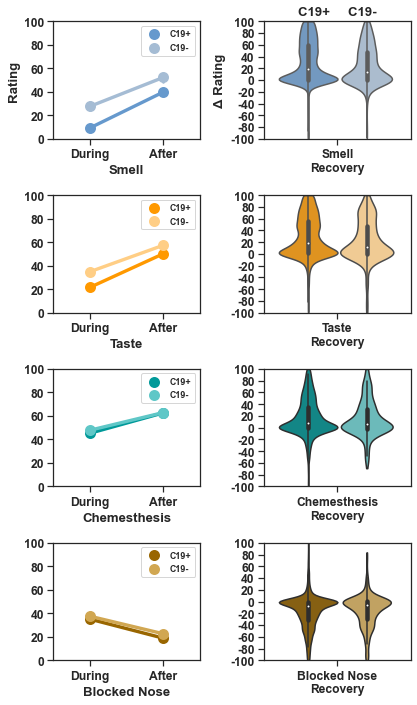

In [52]:
# With filtering out those who have not yet recovered from respiratory illness
figures.CONTEXT = "Supplement"
restrict = s["resp-recovery"] & s["recovery-data"] & (s["lab-covid"] | s['non-covid'])
figures.senses_summary(df.loc[restrict], s, senses, left=["during", "after"], right=["recovery"])

### Entropy and Mutual Information in Survey Questions

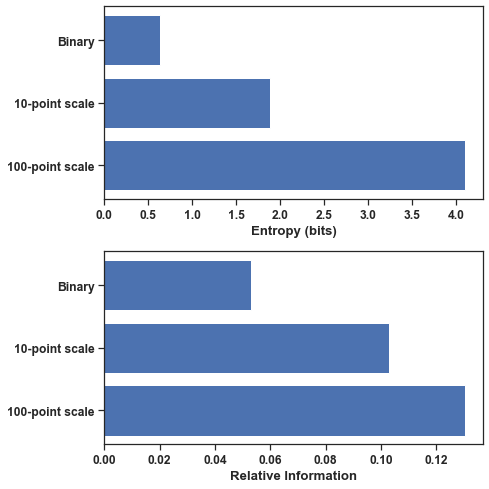

In [53]:
figures.CONTEXT = "Supplement"
figures.plot_entropy(
    df,
    "Smell_during_illness",
    binary="Changes_in_smell_i_cannot_smell_at_all_/_smells_smell_less_strong_than_they_did_before",
)

In [54]:
z = df['Changes_in_smell_i_cannot_smell_at_all_/_smells_smell_less_strong_than_they_did_before'].value_counts(normalize=True)
n = df['Changes_in_smell_i_cannot_smell_at_all_/_smells_smell_less_strong_than_they_did_before'].dropna().count()
p = z[1.0]
p_high = p+2*np.sqrt(p*(1-p)/n)
p_low = p-2*np.sqrt(p*(1-p)/n)
entropy(z, base=2), entropy([p_high, 1-p_high], base=2), entropy([p_low, 1-p_low], base=2)

(0.6378647826865977, 0.6237425859731514, 0.6516204427894479)

In [55]:
def std_entropy(p, n):
    z = 0
    h = entropy(p, base=2)
    for pi in p:
        z += pi*np.log2(pi)**2 - h**2
    return np.sqrt(z/n)

0.6378+ 2*std_entropy(z, n)

0.6473337114341029

### Lab test C19 vs Clinical C19

#### Excludes data on or before 2020/04/18 because that was stated in the pre-registered replication

In [56]:
from datetime import datetime
days = 1 + (datetime.strptime('2020/04/18', '%Y/%m/%d') - datetime.strptime('2020/01/01', '%Y/%m/%d')).days
df_new = df[df['Completion_day']>days]
s_new = {}
for key, value in s.items():
    s_new[key] = value.intersection(df_new.index)
diagnoses_new = {}
for key, value in diagnoses.items():
    if isinstance(value, set):
        diagnoses_new[key] = value.intersection(df_new.index)
    if isinstance(value, dict):
        diagnoses_new[key] = {}
        for key_, value_ in value.items():
            diagnoses_new[key][key_] = value_.intersection(df_new.index)
print(("2020/04/18, the last day of the Parma et al, 2020 data, is the %dth day of the year. "
       "Of all the %d survey responses considered here, %d were not included in Parma et al, 2020 "
       "and can be used for the pre-registered replication of the results reported there.") % (days, len(df), len(df_new)))

2020/04/18, the last day of the Parma et al, 2020 data, is the 109th day of the year. Of all the 15747 survey responses considered here, 9158 were not included in Parma et al, 2020 and can be used for the pre-registered replication of the results reported there.


In [57]:
#df_new.index.intersection(s['lab-covid']).shape, df_new.index.intersection(s['clinical-covid']).shape

In [58]:
#df.index.intersection(s['lab-covid']).shape, df.index.intersection(s['clinical-covid']).shape

In [59]:
#df_old = df[df['Completion_day']<=days]
#df_old.index.intersection(s['lab-covid']).shape, df_old.index.intersection(s['clinical-covid']).shape

/home/rgerkin/Dropbox (ASU)/olfaction/gccr/GCCR002-private/gccr002.py:477: UserWarning: FixedFormatter should only be used together with FixedLocator
  getattr(ax, 'set_%sticklabels' % xy)(new)


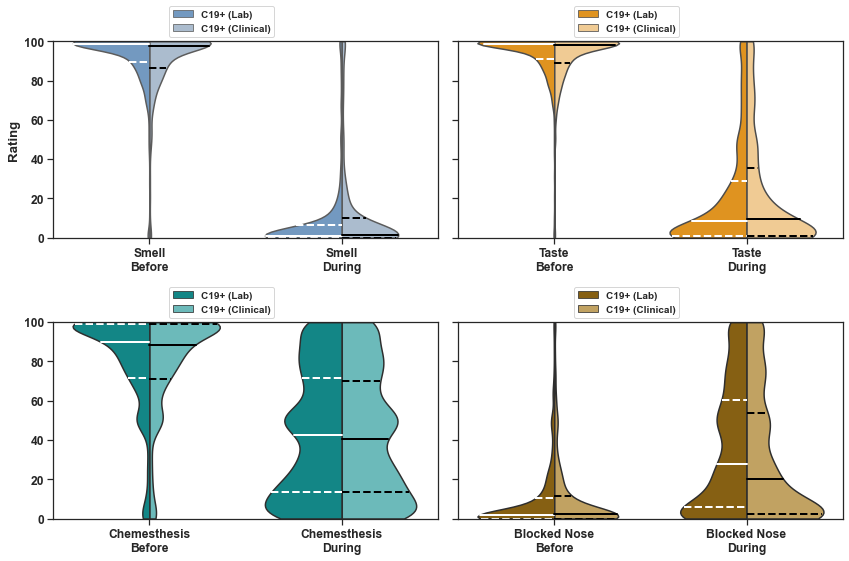

In [60]:
figures.CONTEXT = "Figure S3"
figures.lab_vs_clinical(df_new, s_new, senses)

In [61]:
tables.CONTEXT = 'Table S2'
tables.lab_vs_clinical(df_new, diagnoses_new, senses)

,Smell Change,Taste Change,Chemesthesis Change,Blocked Nose Change
Δ,-5.3,-2.9,0.51,5.5
σ,0,0,38,33
seΔ,-0.077,-0.042,0.0075,0.081
D,-0.18,-0.09,0.014,0.17
p,5.1e-09,0.0062,0.32,6.5e-10


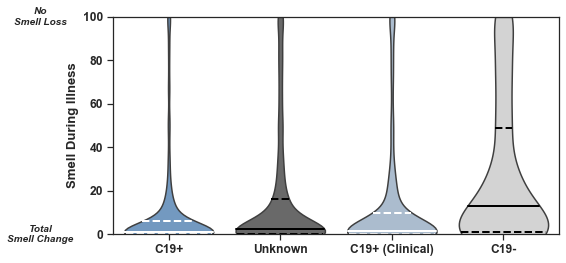

In [62]:
figures.CONTEXT = "Figure S4a"
figures.one_sense_all_diagnoses(df_new, "Smell")

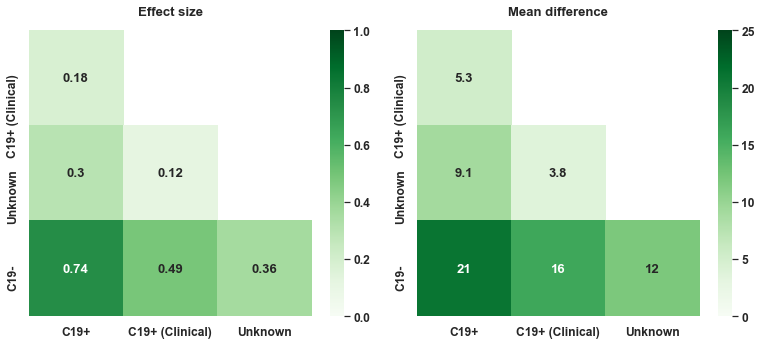

In [63]:
figures.CONTEXT = "Figure S4bc"
figures.effect_size_comparison(df_new, diagnoses_new, "Smell", "change")

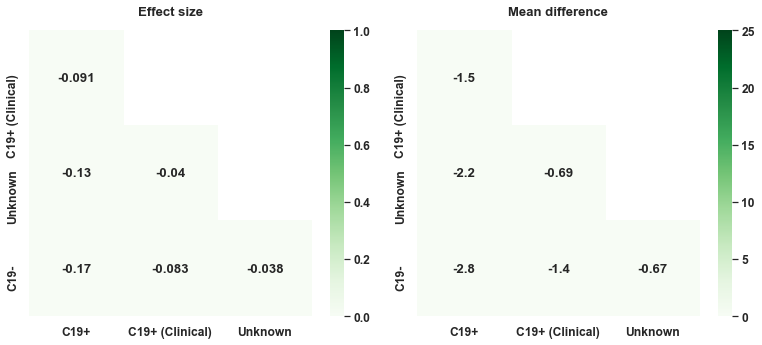

In [64]:
figures.CONTEXT = None
figures.effect_size_comparison(df, diagnoses, "Smell", "before")

### Orthogonality of Nasal Blockage

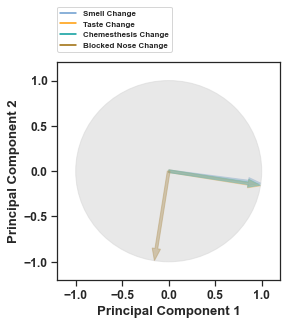

In [65]:
figures.CONTEXT = "Supplement"
figures.pc_senses(df, s, senses)

### Collider bias

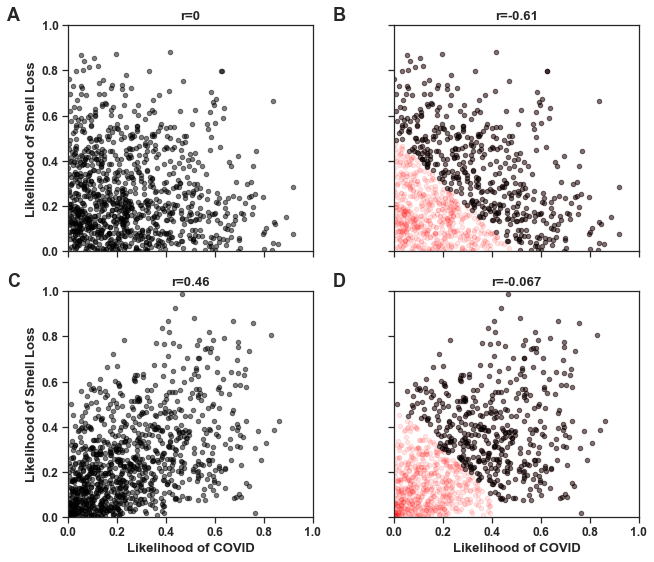

In [66]:
figures.CONTEXT = "Supplement"
figures.collider_bias()

In [67]:
# figures.CONTEXT = "Not Used"
# figures.alt_senses_summary(df, s, senses)

In [68]:
# tables.all_compare(df, diagnoses, "Chemesthesis", "change")

In [69]:
# tables.all_compare(df, diagnoses, "Chemesthesis", "recovery")

In [70]:
# figures.CONTEXT = "Unused"
# figures.effect_size_comparison(df, diagnoses, "Smell", "recovery")

In [71]:
# tables.all_compare(df, diagnoses, "Smell", "during")

In [72]:
# tables.all_compare(df, diagnoses, "Taste", "after")

In [73]:
# tables.all_compare(df, diagnoses, "Taste", "recovery")

In [74]:
# figures.CONTEXT = "Supplement"
# figures.numeric_by_categorical(
#    df, s, "Smell_during_illness", "Gender", restrict=(s["female"] | s["male"])
# )

In [75]:
# figures.CONTEXT = "Supplement"
# figures.numeric_by_status(df, s, "Age")

In [76]:
# figures.CONTEXT = "Supplement"
# figures.numeric_by_status_split(
#    df, s, "Age", "Gender", restrict=(s["male"] | s["female"])
# )

In [77]:
# tranche_compare(clf, X, y, s)

In [78]:
# figures.CONTEXT = "Supplement"
# figures.downsample_auc(lrcv, X, y)

In [79]:
# figures.CONTEXT = "Not Used"
# figures.predict_young_old(df, lr, X, y, s)

In [80]:
# figures.CONTEXT = "Not used"
# figures.numeric_by_status_split(
#    df, s, "Chemesthesis_change_illness", "Gender", restrict=(s["male"] | s["female"])
# )

In [81]:
# double_feature_aucs = get_tuple_feature_aucs(lrcv, X, y, 2, sample_weight=None)
# double_feature_aucs.head(15)

In [82]:
# figures.plot_double_features(double_features)

In [83]:
# figures.old_summary(Xu, s)

In [84]:
# figures.chem_and_block(df, s)

In [85]:
# figures.CONTEXT = "Supplement"
# figures.nmf_cluster(Xn, 3, classes)

In [86]:
# figures.draw_ontology(df, classes["features"])

In [87]:
# figures.CONTEXT = "Supplement"
# three_features = ["Symptoms_changes_in_smell", "Symptoms_dry_cough", "Symptoms_fever"]
# venn_covid(Xu, s["lab-covid"], three_features, label="C19+ (Lab)")

In [88]:
# figures.CONTEXT = "Supplement"
# venn_covid(Xu, s["non-covid"], three_features, label="C19- (Lab)")

In [89]:
# Signficant but small effect size.  Ignore.
# df["Did_smell_recover"] = df["Smell_recovery_illness"] > 33.3
# chem_block_categories = {
#    key: value for key, value in s.items() if "chem" in key or "block" in key
# }
# feature_contingency(df, chem_block_categories, "Did_smell_recover", normalize=1)

In [90]:
# df["Has_chemesthesis_change"] = df["Chemesthesis_change_illness"] < -50
# feature_contingency(df, three_clusters, "Has_chemesthesis_change", normalize=1)

In [91]:
# df["Has_chemesthesis_change"] = df["Chemesthesis_change_illness"] < -50
# feature_contingency(df, two_clusters_pos, "Has_chemesthesis_change", normalize=1)

In [92]:
# figures.CONTEXT = "Not used"
# figures.chem_and_block(df, s)

In [93]:
# figures.CONTEXT = "Supplement"
# figures.age_and_gender(df, s, three_clusters)

### Extra summary tables of symptoms and subject characteristics

In [94]:
df_ohe = pd.get_dummies(df.drop('Test_Name', axis=1))

In [95]:
tables.CONTEXT = 'Table S4'
tables.symptoms_by_status(df_ohe, 
                          {'C19+': s['lab-covid'], 'C19-': s['non-covid']}, 
                          'typical',
                          classes,
                          formatting='%.3g').head()

COVID-19 Status,C19+,C19-
Abdominal Pain,0.169,0.203
Blocked Nose After,18.8 +/- 24.5,22.8 +/- 26
Blocked Nose Before,9.37 +/- 17.3,11.8 +/- 19.6
Blocked Nose Change,25.6 +/- 32.7,26 +/- 32.4
Blocked Nose During,35 +/- 32,37.8 +/- 32.8


In [96]:
tables.CONTEXT = 'Table S5'
tables.symptoms_by_status(df_ohe, 
                          {'C19+': s['lab-covid'], 'C19-': s['non-covid']}, 
                          'chemosensory',
                          classes,
                          formatting='%.3g').head()

COVID-19 Status,C19+,C19-
Anosmia/Hyposmia,0.887,0.647
Changes In Bitter,0.412,0.324
Changes In Food Flavor,0.826,0.679
Changes In Salty,0.459,0.353
Changes In Savory,0.353,0.288


In [97]:
tables.CONTEXT = 'Table S6'
tables.symptoms_by_status(df_ohe, 
                          {'C19+': s['lab-covid'], 'C19-': s['non-covid']}, 
                          'history',
                          classes,
                          formatting='%.3g').head()

COVID-19 Status,C19+,C19-
Cancer+Chemo/Radiation,0.00261,0.00195
Cancer-Chemo/Radiation,0.00339,0.0078
Chronic Sinus Problems,0.0342,0.0682
Cigarette Frequency,4.36 +/- 9.42,6.56 +/- 11.2
Cigarette Use,0.638,0.662


In [98]:
tables.CONTEXT = 'Table S7'
tables.symptoms_by_status(df_ohe, 
                          {'C19+': s['lab-covid'], 'C19-': s['non-covid']}, 
                          'demographic',
                          classes,
                          formatting='%.3g',
                          drop_features=['Gender 2.0', 'Gender 3.0']).head()

COVID-19 Status,C19+,C19-
Age,40.6 +/- 12,43.2 +/- 12.1
Gender F,0.75,0.782
Gender M,0.248,0.216


In [99]:
# Break out recovery from respiratory symptoms into categories (for C19+)
df_ohe.loc[s['lab-covid'], 'Recovery_y/n'].value_counts(normalize=True).round(3).sort_index()

0.0    0.124
1.0    0.424
2.0    0.420
3.0    0.031
Name: Recovery_y/n, dtype: float64

In [100]:
# Break out recovery from respiratory symptoms into categories (for C19-)
df_ohe.loc[s['non-covid'], 'Recovery_y/n'].value_counts(normalize=True).round(3).sort_index()

0.0    0.160
1.0    0.508
2.0    0.293
3.0    0.039
Name: Recovery_y/n, dtype: float64

### Collider bias check with matched sampling

In [101]:
c19_plus = df.loc[s['lab-covid']].reset_index()[['UniqueID', 'Age', 'Gender']]
c19_plus['status'] = 0
c19_minus = df.loc[s['non-covid']].reset_index()[['UniqueID', 'Age', 'Gender']]
c19_minus['status'] = 1
from pymatch.Matcher import Matcher
m = Matcher(c19_plus, c19_minus, yvar="status", exclude=['UniqueID'])
np.random.seed(0)
m.fit_scores(balance=True, nmodels=100)

Formula:
status ~ Age+Gender
n majority: 4148
n minority: 546
Fitting Models on Balanced Samples: 100\100
Average Accuracy: 55.72%


Propensity Scores have not been calculated. Using defaults...
Fitting Models on Balanced Samples: 10\10
Average Accuracy: 56.09%


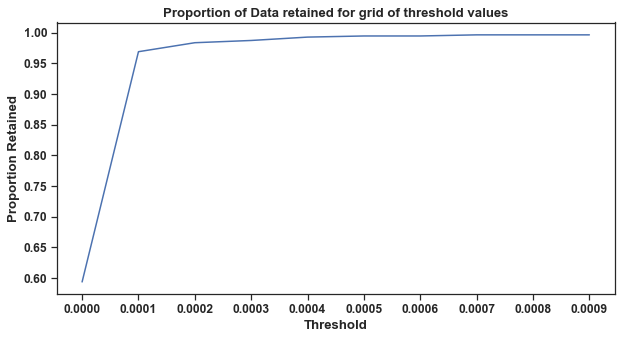

In [102]:
m.tune_threshold(method='random')

In [103]:
m.match(method="min", nmatches=1, threshold=0.0004)

/home/rgerkin/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/rgerkin/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


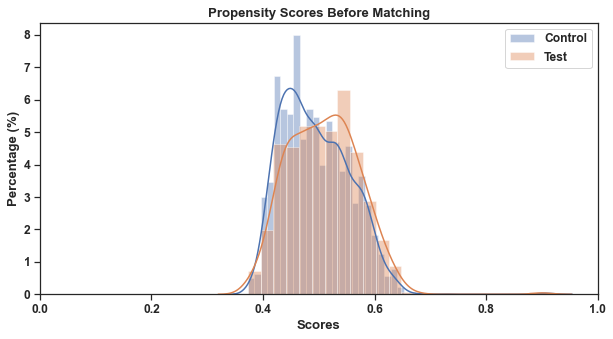

In [104]:
m.plot_scores()

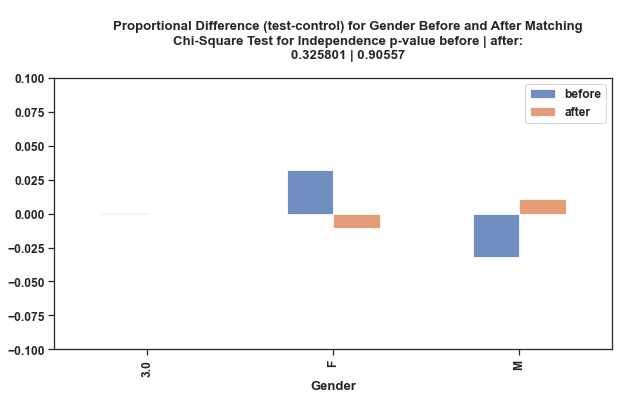

In [105]:
m.compare_categorical()

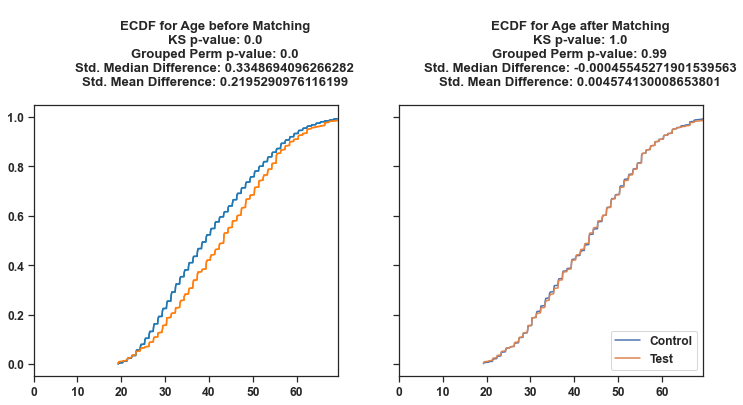

In [106]:
m.compare_continuous()

In [107]:
X = Xn.loc[s["lab-covid"] | s["non-covid"], features].sort_index()
y = X.index.to_series().isin(s["lab-covid"])
sample_weight = None

In [108]:
X_matched = X.loc[m.matched_data['UniqueID']]
y_matched = y.loc[m.matched_data['UniqueID']]

In [109]:
# Single feature models for matched data
single_feature_aucs_matched = get_tuple_feature_aucs(
    lrcv, X_matched, y_matched, 1, sample_weight=sample_weight, nicify_=False
)
single_feature_aucs_matched.head(5)

,ROC AUC
Symptom set,
Smell_during_illness,0.711
Smell_change_illness,0.690
Taste_change_illness,0.654
Taste_during_illness,0.650
Changes_in_smell_i_cannot_smell_at_all_/_smells_smell_less_strong_than_they_did_before,0.622


(20.0, 75.0)

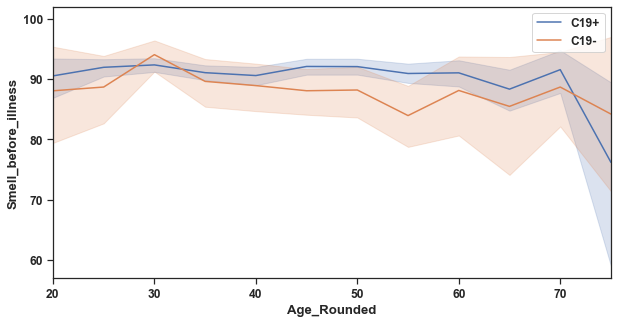

In [110]:
df['Age_Rounded'] = (df['Age']/5).round()*5  # Round to the nearest 5 years for aggregation
sns.lineplot(data=df.loc[s['lab-covid']], x='Age_Rounded', y='Smell_before_illness', label='C19+')
sns.lineplot(data=df.loc[s['non-covid']], x='Age_Rounded', y='Smell_before_illness', label='C19-')
plt.xlim(20, 75)
#df = df.drop('Age_Rounded', axis=1)

In [111]:
# ANOVA for Age and Smell Before Illness
anova(df.loc[df['COVID Status'].notnull()], 'Smell_before_illness', ['Age_Rounded', 'COVID_Status'])

,Source,SS,DF,MS,F,p-unc,np2
0,Age_Rounded,20.896273,13.0,1.607406,1.616023,0.073209,0.004480
1,COVID_Status,0.714271,1.0,0.714271,0.718100,0.396811,0.000154
2,Age_Rounded * COVID_Status,11.222023,13.0,0.863233,0.867860,0.587220,0.002411
3,Residual,4643.108515,4668.0,0.994668,NaN,NaN,NaN


In [112]:
# Contingency table and p-value for smoking history
feature_contingency(df, diagnoses["clean"], 'Combustible_cigarette_use')

p = 0.14


,C19+,C19-
Cigarette Use,,
0.0,306,29
0.5,2389,311
1.0,1453,206


In [113]:
# Bin smoking frequency into 5 day/month bins.
df['cig_5'] = (df['Combustible_cigarette_frequency']/5).round()*5
feature_contingency(df, diagnoses["clean"], 'cig_5', normalize=0)

p = 0.06


,C19+,C19-
Cig 5,,
0.0,0.78,0.70
5.0,0.05,0.03
10.0,0.03,0.05
15.0,0.02,0.03
20.0,0.02,0.03
25.0,0.01,0.02
30.0,0.09,0.15


In [115]:
finish = time.time()
print("Notebook took %d seconds to execute" % (finish - start))

Notebook took 1112 seconds to execute
